In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
dropout_value = 0.06
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
           
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
img_arr = []
img_pred = []
img_org = []

def train(model, device, train_loader, optimizer, epoch,scheduler, l1_loss, lam_val):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    #L1 Regularization
    if l1_loss:
      reg_loss = 0
      for param in model.parameters():
          reg_loss += torch.sum(abs(param))

      factor = lam_val
      loss += factor * reg_loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()

  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i , c in  enumerate(wrong_idx.tolist()):
                sample = wrong_samples[i].cpu()
                wrong_pred = wrong_preds[i].cpu()
                actual_pred = actual_preds[i].cpu()
                # Undo normalization
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                img_arr.append(img)
                img_pred.append(wrong_pred.item())
                img_org.append(actual_pred.item())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
!pip install mlcrate
import mlcrate as mlc

In [11]:
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
logger = mlc.LinewiseCSVWriter('train_log.csv', header=['epoch_count', 'test_losses', 'test_acc', 'lambda_val'])

non_loss = []
L1_loss = []
L2_loss = []
both_loss = []
l1_loss = False
ep = 40
lambda_val = [0.001, 0.000001]

for lam_val in lambda_val:
  for i in range(4):
    if i == 0:
      weight_decay = 0
      l1_loss = False
    if i == 1: 
      weight_decay = 0
      l1_loss = True
    if i == 2: 
      weight_decay = lam_val
      l1_loss = False
    if i == 3: 
      weight_decay = lam_val
      l1_loss = True

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=ep)

    for epoch in range(ep):
        train(model, device, train_loader, optimizer, epoch, scheduler, l1_loss, lam_val)
        print('Epoch:', epoch,'LR:', scheduler.get_lr())
        test(model, device, test_loader)
    epoch_count = range(0, len(test_losses))
    if i == 0:
      non_loss = test_losses
      non_acc = test_acc
    if i == 1: 
      L1_loss = test_losses
      L1_acc = test_acc
    if i == 2: 
      L2_loss = test_losses
      L2_acc = test_acc
    if i == 3: 
      both_loss = test_losses
      both_acc = test_acc
    print("********************* L", len(test_losses))
    print("********************* A", len(test_acc))
    print("********************* E", len(epoch_count))
    logger.write([epoch_count, test_losses, test_acc, lam_val])
    test_losses = []
    test_acc = []


Loss=0.11122200638055801 Batch_id=468 Accuracy=77.95: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1188, Accuracy: 9711/10000 (97.11%)



Loss=0.1287054866552353 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]  

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9768/10000 (97.68%)



Loss=0.05938062444329262 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9850/10000 (98.50%)



Loss=0.05174484848976135 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]  

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9880/10000 (98.80%)



Loss=0.02509632147848606 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]  

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9849/10000 (98.49%)



Loss=0.08768673986196518 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]  

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9904/10000 (99.04%)



Loss=0.13225378096103668 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]  

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9912/10000 (99.12%)



Loss=0.0045347660779953 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]   

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)



Loss=0.014163926243782043 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s] 

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)



Loss=0.022474506869912148 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9905/10000 (99.05%)



Loss=0.19765906035900116 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]  

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)



Loss=0.017808422446250916 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s] 

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)



Loss=0.04406410828232765 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]  

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9910/10000 (99.10%)



Loss=0.028273150324821472 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s] 

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9926/10000 (99.26%)



Loss=0.030582213774323463 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s] 

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)



Loss=0.0735841616988182 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]   

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)



Loss=0.006581117864698172 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)



Loss=0.06802228838205338 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]  

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)



Loss=0.008722464554011822 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 36.62it/s] 

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9939/10000 (99.39%)



Loss=0.006229192018508911 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s] 

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)



Loss=0.002355024218559265 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s] 

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)



Loss=0.03407755866646767 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]  

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)



Loss=0.020505821332335472 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s] 

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)



Loss=0.0027185578364878893 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)



Loss=0.0012982686748728156 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)



Loss=0.03791796788573265 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:12<00:00, 38.53it/s]  

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)



Loss=0.027706464752554893 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]  

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)



Loss=0.010565340518951416 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:12<00:00, 38.32it/s]  

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)



Loss=0.008070617914199829 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s] 

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)



Loss=0.0046185157261788845 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



Loss=0.006737381219863892 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s] 

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)



Loss=0.030799567699432373 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)



Loss=0.002447043778374791 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]  


Epoch: 32 LR: [0.014636545284495312]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9947/10000 (99.47%)



Loss=0.00389465200714767 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]   

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)



Loss=0.008778889663517475 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]  

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)



Loss=0.0009317199583165348 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:12<00:00, 37.36it/s] 

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)



Loss=0.008343364112079144 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]  

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)



Loss=0.020841995254158974 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]  

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9950/10000 (99.50%)



Loss=0.0012604892253875732 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s] 

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9951/10000 (99.51%)



Loss=0.0016306539764627814 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s] 


Epoch: 39 LR: [4.0143079121884904e-07]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

********************* L 40
********************* A 40
********************* E 40


Loss=1.2688618898391724 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)



Loss=0.9058374762535095 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:13<00:00, 35.94it/s]

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)



Loss=0.5848946571350098 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9871/10000 (98.71%)



Loss=0.5326055288314819 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s] 

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9704/10000 (97.04%)



Loss=0.42793259024620056 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9780/10000 (97.80%)



Loss=0.4608543813228607 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s] 

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0957, Accuracy: 9717/10000 (97.17%)



Loss=0.4389123320579529 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s] 

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 9632/10000 (96.32%)



Loss=0.39485451579093933 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9800/10000 (98.00%)



Loss=0.5258105993270874 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s] 

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1969, Accuracy: 9429/10000 (94.29%)



Loss=0.3512375056743622 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3602, Accuracy: 8854/10000 (88.54%)



Loss=0.3846740424633026 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s] 

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1032, Accuracy: 9692/10000 (96.92%)



Loss=0.4056130051612854 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s] 

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1368, Accuracy: 9588/10000 (95.88%)



Loss=0.345123827457428 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]  

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1142, Accuracy: 9664/10000 (96.64%)



Loss=0.38048404455184937 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1072, Accuracy: 9687/10000 (96.87%)



Loss=0.42446497082710266 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3418, Accuracy: 8879/10000 (88.79%)



Loss=0.33796340227127075 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9757/10000 (97.57%)



Loss=0.3594306409358978 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1489, Accuracy: 9550/10000 (95.50%)



Loss=0.43621230125427246 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1498, Accuracy: 9545/10000 (95.45%)



Loss=0.3661794364452362 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s] 

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1414, Accuracy: 9608/10000 (96.08%)



Loss=0.32278719544410706 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5350, Accuracy: 8548/10000 (85.48%)



Loss=0.34910833835601807 Batch_id=468 Accuracy=96.49: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4563, Accuracy: 8679/10000 (86.79%)



Loss=0.41439950466156006 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1207, Accuracy: 9627/10000 (96.27%)



Loss=0.4105640649795532 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s] 

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1543, Accuracy: 9488/10000 (94.88%)



Loss=0.3684481680393219 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s] 

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2258, Accuracy: 9289/10000 (92.89%)



Loss=0.3455616235733032 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s] 

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2421, Accuracy: 9227/10000 (92.27%)



Loss=0.2860906720161438 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s] 

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1230, Accuracy: 9618/10000 (96.18%)



Loss=0.4322457015514374 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s] 

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1014, Accuracy: 9689/10000 (96.89%)



Loss=0.3440284729003906 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9732/10000 (97.32%)



Loss=0.33049720525741577 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:12<00:00, 36.50it/s]

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1306, Accuracy: 9607/10000 (96.07%)



Loss=0.35461729764938354 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]


Epoch: 29 LR: [0.028295323462426913]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0914, Accuracy: 9751/10000 (97.51%)



Loss=0.285078227519989 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]  


Epoch: 30 LR: [0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1348, Accuracy: 9595/10000 (95.95%)



Loss=0.2926052212715149 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9748/10000 (97.48%)



Loss=0.30195558071136475 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9817/10000 (98.17%)



Loss=0.30920952558517456 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9839/10000 (98.39%)



Loss=0.26232826709747314 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9829/10000 (98.29%)



Loss=0.23111486434936523 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9880/10000 (98.80%)



Loss=0.1807856261730194 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s] 

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9869/10000 (98.69%)



Loss=0.1563493013381958 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s] 

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9899/10000 (98.99%)



Loss=0.19059555232524872 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9900/10000 (99.00%)



Loss=0.17609664797782898 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9911/10000 (99.11%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.07506516575813293 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s] 


Epoch: 0 LR: [0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9880/10000 (98.80%)



Loss=0.03256148099899292 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s] 

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9878/10000 (98.78%)



Loss=0.0789538100361824 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]  

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9794/10000 (97.94%)



Loss=0.07565930485725403 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s] 

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9877/10000 (98.77%)



Loss=0.03568638488650322 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 38.62it/s] 

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9841/10000 (98.41%)



Loss=0.036021437495946884 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9876/10000 (98.76%)



Loss=0.025892242789268494 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9883/10000 (98.83%)



Loss=0.04834907874464989 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s] 

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9858/10000 (98.58%)



Loss=0.026864683255553246 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9851/10000 (98.51%)



Loss=0.05981169268488884 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9834/10000 (98.34%)



Loss=0.018433064222335815 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9849/10000 (98.49%)



Loss=0.09170889854431152 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 37.45it/s] 

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0937, Accuracy: 9717/10000 (97.17%)



Loss=0.05082816258072853 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s] 

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9805/10000 (98.05%)



Loss=0.06271474808454514 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s] 

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9857/10000 (98.57%)



Loss=0.028306392952799797 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9831/10000 (98.31%)



Loss=0.07006845623254776 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s] 

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9831/10000 (98.31%)



Loss=0.0555851049721241 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]  

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9815/10000 (98.15%)



Loss=0.05208925902843475 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s] 

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9824/10000 (98.24%)



Loss=0.06504779309034348 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s] 

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9870/10000 (98.70%)



Loss=0.03774527832865715 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s] 


Epoch: 19 LR: [0.08116521259079444]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9847/10000 (98.47%)



Loss=0.0469534695148468 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]  

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9837/10000 (98.37%)



Loss=0.03309125453233719 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s] 

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0890, Accuracy: 9730/10000 (97.30%)



Loss=0.017695682123303413 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]


Epoch: 22 LR: [0.06650279626689218]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9876/10000 (98.76%)



Loss=0.015527273528277874 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9854/10000 (98.54%)



Loss=0.06823812425136566 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s] 

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9768/10000 (97.68%)



Loss=0.09676608443260193 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s] 

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9886/10000 (98.86%)



Loss=0.037274811416864395 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9865/10000 (98.65%)



Loss=0.04810002073645592 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9878/10000 (98.78%)



Loss=0.07016803324222565 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s] 

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9885/10000 (98.85%)



Loss=0.05851973965764046 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s] 

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9880/10000 (98.80%)



Loss=0.02046271599829197 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s] 

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9888/10000 (98.88%)



Loss=0.02258857525885105 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 37.28it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9854/10000 (98.54%)



Loss=0.042604073882102966 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:11<00:00, 39.37it/s]

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9906/10000 (99.06%)



Loss=0.015231174416840076 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99.09%)



Loss=0.012091808021068573 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]


Epoch: 34 LR: [0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99.09%)



Loss=0.03256690874695778 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s] 

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9918/10000 (99.18%)



Loss=0.1612936407327652 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 38.76it/s]  

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9935/10000 (99.35%)



Loss=0.025230376049876213 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s] 


Epoch: 37 LR: [0.001251339077347576]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)



Loss=0.009140665642917156 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)



Loss=0.017460187897086143 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s] 

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.2958710193634033 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s] 

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9895/10000 (98.95%)



Loss=0.3208594024181366 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 33.50it/s] 

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1075, Accuracy: 9693/10000 (96.93%)



Loss=0.3473886251449585 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1225, Accuracy: 9651/10000 (96.51%)



Loss=0.33766645193099976 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9756/10000 (97.56%)



Loss=0.35132670402526855 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9700/10000 (97.00%)



Loss=0.32176247239112854 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]


Epoch: 5 LR: [0.05201339936426283]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1483, Accuracy: 9592/10000 (95.92%)



Loss=0.3061809241771698 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s] 


Epoch: 6 LR: [0.06443841342999641]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2178, Accuracy: 9360/10000 (93.60%)



Loss=0.4039345383644104 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s] 

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3467, Accuracy: 8941/10000 (89.41%)



Loss=0.31517571210861206 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2741, Accuracy: 9110/10000 (91.10%)



Loss=0.3827569782733917 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2765, Accuracy: 9165/10000 (91.65%)



Loss=0.5504825115203857 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s] 

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2809, Accuracy: 9141/10000 (91.41%)



Loss=0.37057551741600037 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1581, Accuracy: 9493/10000 (94.93%)



Loss=0.3765697479248047 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s] 

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2604, Accuracy: 9179/10000 (91.79%)



Loss=0.45214635133743286 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2176, Accuracy: 9340/10000 (93.40%)



Loss=0.4577147364616394 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s] 

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2815, Accuracy: 9099/10000 (90.99%)



Loss=0.348781019449234 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]  

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2295, Accuracy: 9335/10000 (93.35%)



Loss=0.3379599153995514 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2205, Accuracy: 9261/10000 (92.61%)



Loss=0.37046414613723755 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2020, Accuracy: 9358/10000 (93.58%)



Loss=0.31853795051574707 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]


Epoch: 18 LR: [0.08534693853699324]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2117, Accuracy: 9441/10000 (94.41%)



Loss=0.323991984128952 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]  

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1425, Accuracy: 9627/10000 (96.27%)



Loss=0.40550696849823 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]   

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1598, Accuracy: 9546/10000 (95.46%)



Loss=0.3348671495914459 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s] 

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4962, Accuracy: 8424/10000 (84.24%)



Loss=0.3807254731655121 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s] 

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1137, Accuracy: 9655/10000 (96.55%)



Loss=0.4663400948047638 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s] 


Epoch: 23 LR: [0.0611145402316058]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2761, Accuracy: 9138/10000 (91.38%)



Loss=0.3287696838378906 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s] 

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1793, Accuracy: 9461/10000 (94.61%)



Loss=0.4273874759674072 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s] 

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1690, Accuracy: 9489/10000 (94.89%)



Loss=0.27651819586753845 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]


Epoch: 26 LR: [0.04439011241507181]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3111, Accuracy: 9038/10000 (90.38%)



Loss=0.2990686297416687 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1126, Accuracy: 9681/10000 (96.81%)



Loss=0.3130139112472534 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s] 

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1088, Accuracy: 9654/10000 (96.54%)



Loss=0.37476882338523865 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1163, Accuracy: 9655/10000 (96.55%)



Loss=0.3111713230609894 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s] 

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1384, Accuracy: 9588/10000 (95.88%)



Loss=0.21439649164676666 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9809/10000 (98.09%)



Loss=0.21648813784122467 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0788, Accuracy: 9795/10000 (97.95%)



Loss=0.2007903903722763 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s] 

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0821, Accuracy: 9768/10000 (97.68%)



Loss=0.22722965478897095 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0897, Accuracy: 9736/10000 (97.36%)



Loss=0.25147971510887146 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9864/10000 (98.64%)



Loss=0.22761985659599304 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9870/10000 (98.70%)



Loss=0.16092991828918457 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]


Epoch: 37 LR: [0.001251339077347576]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9893/10000 (98.93%)



Loss=0.14770656824111938 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9915/10000 (99.15%)



Loss=0.13906912505626678 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9920/10000 (99.20%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.10986117273569107 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s] 

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9871/10000 (98.71%)



Loss=0.04593500867486 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]    

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9848/10000 (98.48%)



Loss=0.01753566600382328 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9872/10000 (98.72%)



Loss=0.019461339339613914 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9866/10000 (98.66%)



Loss=0.040880367159843445 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9893/10000 (98.93%)



Loss=0.01626812480390072 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]  

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9892/10000 (98.92%)



Loss=0.07397731393575668 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s] 

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9899/10000 (98.99%)



Loss=0.041976094245910645 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s] 

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)



Loss=0.05929811671376228 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]  

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9893/10000 (98.93%)



Loss=0.0031962692737579346 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99.04%)



Loss=0.010005474090576172 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s] 


Epoch: 10 LR: [0.09837079160934131]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9904/10000 (99.04%)



Loss=0.04057120904326439 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]  

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)



Loss=0.03550392761826515 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]  

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9899/10000 (98.99%)



Loss=0.012147113680839539 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s] 

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9890/10000 (98.90%)



Loss=0.04301007464528084 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]  

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9900/10000 (99.00%)



Loss=0.015639886260032654 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s] 

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)



Loss=0.003687327029183507 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)



Loss=0.006934484001249075 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s] 

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)



Loss=0.04844880476593971 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]  

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.21%)



Loss=0.020223939791321754 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s] 

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)



Loss=0.045628760010004044 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s] 

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)



Loss=0.003927876707166433 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s] 

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)



Loss=0.027185941115021706 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s] 

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)



Loss=0.015803849324584007 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s] 

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)



Loss=0.009326428174972534 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s] 

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9939/10000 (99.39%)



Loss=0.0021415899973362684 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)



Loss=0.04519541189074516 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]  

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)



Loss=0.005516072269529104 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)



Loss=0.012446816079318523 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s] 

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)



Loss=0.04172521457076073 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]  

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)



Loss=0.01993226446211338 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]  

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)



Loss=0.002370427129790187 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)



Loss=0.012526403181254864 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s] 

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)



Loss=0.041868846863508224 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s] 

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)



Loss=0.02222316898405552 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]  

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)



Loss=0.03648020327091217 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]  

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)



Loss=0.018494987860322 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]    

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)



Loss=0.0033632516860961914 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)



Loss=0.005790889263153076 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s] 

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)



Loss=0.007152924779802561 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s] 

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.03717508912086487 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]  


Epoch: 0 LR: [0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



Loss=0.0520445816218853 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]   

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)



Loss=0.014111523516476154 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)



Loss=0.021717719733715057 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s] 

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)



Loss=0.012146810069680214 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 36.76it/s] 

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)



Loss=0.05518033728003502 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]  

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9935/10000 (99.35%)



Loss=0.014490015804767609 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.23it/s] 

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)



Loss=0.07646747678518295 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]  

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)



Loss=0.03029264137148857 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]  

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)



Loss=0.011454927735030651 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)



Loss=0.04346112534403801 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]  

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)



Loss=0.004293845966458321 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s] 

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9910/10000 (99.10%)



Loss=0.011555289849638939 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s] 

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9913/10000 (99.13%)



Loss=0.08248429000377655 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]  

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)



Loss=0.0035276804119348526 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)



Loss=0.04154818877577782 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]  

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9926/10000 (99.26%)



Loss=0.019606951624155045 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)



Loss=0.028043393045663834 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s] 

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9927/10000 (99.27%)



Loss=0.020073600113391876 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s] 

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)



Loss=0.04935510829091072 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]  

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)



Loss=0.028815366327762604 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s] 

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)



Loss=0.024128053337335587 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s] 

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)



Loss=0.05128180608153343 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]  

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9940/10000 (99.40%)



Loss=0.02379998378455639 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]  

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)



Loss=0.0035567120648920536 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)



Loss=0.08174992352724075 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]  

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)



Loss=0.01894838735461235 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]  

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)



Loss=0.01741085574030876 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]  

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)



Loss=0.009996829554438591 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s] 

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)



Loss=0.0019003476481884718 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)



Loss=0.017951807007193565 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s] 

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)



Loss=0.005910966545343399 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)



Loss=0.00427568843588233 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]  

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)



Loss=0.03511069715023041 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]  

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)



Loss=0.0062165893614292145 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)



Loss=0.045854322612285614 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s] 

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)



Loss=0.009996111504733562 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s] 

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)



Loss=0.007252838462591171 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s] 

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)



Loss=0.04378914833068848 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]  

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)



Loss=0.004468986298888922 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s] 

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.04359124228358269 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]   

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)



Loss=0.006860136985778809 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s] 

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)



Loss=0.015422701835632324 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9941/10000 (99.41%)



Loss=0.052576784044504166 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]  

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)



Loss=0.024535730481147766 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s] 

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)



Loss=0.04638822004199028 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]  

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)



Loss=0.012784510850906372 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s] 

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)



Loss=0.003444274188950658 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.06it/s] 

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)



Loss=0.008156741969287395 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]  

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)



Loss=0.04781273007392883 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]  

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)



Loss=0.015335758216679096 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]  

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)



Loss=0.0519377775490284 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 37.41it/s]   

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)



Loss=0.03069419600069523 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]  

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)



Loss=0.0010954737663269043 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)



Loss=0.05349947139620781 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]  

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9933/10000 (99.33%)



Loss=0.05802324786782265 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]   

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)



Loss=0.029703805223107338 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.30it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)



Loss=0.11459451913833618 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.19it/s]  

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)



Loss=0.019512394443154335 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s] 

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)



Loss=0.01358113158494234 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]  

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)



Loss=0.05365905165672302 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]  

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)



Loss=0.0027052462100982666 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.43it/s]

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)



Loss=0.0006686349515803158 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)



Loss=0.0762673169374466 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.99it/s]   

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)



Loss=0.014680157415568829 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]  

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)



Loss=0.0005473792552947998 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 37.12it/s]

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)



Loss=0.0022704105358570814 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)



Loss=0.011292894370853901 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)



Loss=0.02497979998588562 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]  

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)



Loss=0.0012991130352020264 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)



Loss=0.019289622083306313 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]  

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)



Loss=0.024496182799339294 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:12<00:00, 37.91it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)



Loss=0.026873787865042686 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s] 

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)



Loss=0.022580737248063087 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 37.54it/s]  

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)



Loss=0.005140314344316721 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s] 

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)



Loss=0.04114420339465141 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]   

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)



Loss=0.055952038615942 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]    

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)



Loss=0.00602016830816865 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]  

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9938/10000 (99.38%)



Loss=0.013021518476307392 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s] 

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)



Loss=0.002831359626725316 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]  

Epoch: 39 LR: [4.0143079121884904e-07]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

********************* L 40
********************* A 40
********************* E 40


Loss=0.01558213122189045 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]  

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)



Loss=0.06316792964935303 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]  

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)



Loss=0.013661754317581654 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s] 

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)



Loss=0.029214758425951004 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s] 

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)



Loss=0.011630079708993435 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s] 

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)



Loss=0.025012042373418808 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s] 

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)



Loss=0.023156262934207916 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s] 

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)



Loss=0.044881317764520645 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s] 

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)



Loss=0.007612858898937702 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s] 

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)



Loss=0.022951962426304817 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s] 

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)



Loss=0.011020559817552567 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s] 

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)



Loss=0.002309278817847371 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s] 

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



Loss=0.0028089345432817936 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)



Loss=0.0643201470375061 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]   

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)



Loss=0.007809032686054707 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s] 

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)



Loss=0.029877491295337677 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s] 

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)



Loss=0.012975327670574188 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s] 

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)



Loss=0.00457780109718442 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]  

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)



Loss=0.03408019244670868 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]  

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)



Loss=0.032586902379989624 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s] 

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9945/10000 (99.45%)



Loss=0.016043949872255325 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s] 

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)



Loss=0.005836907774209976 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s] 

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)



Loss=0.04143993556499481 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]  

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9944/10000 (99.44%)



Loss=0.005927505902945995 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s] 

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)



Loss=0.06501612812280655 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]  

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)



Loss=0.047448430210351944 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s] 

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)



Loss=0.004574710503220558 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s] 

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)



Loss=0.007045004516839981 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s] 

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)



Loss=0.0700787603855133 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]   

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)



Loss=0.004110589623451233 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s] 

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)



Loss=0.003350853221490979 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s] 

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)



Loss=0.008943934924900532 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s] 

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)



Loss=0.03624553233385086 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]  

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)



Loss=0.005230213049799204 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s] 

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)



Loss=0.020580928772687912 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s] 

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)



Loss=0.035381805151700974 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s] 

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)



Loss=0.016362523660063744 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s] 

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)



Loss=0.00818626955151558 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]  

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)



Loss=0.021600089967250824 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s] 

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)



Loss=0.008543885312974453 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s] 

Epoch: 39 LR: [4.0143079121884904e-07]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

********************* L 40
********************* A 40
********************* E 40


In [13]:
import pandas as pd
df = pd.read_csv('train_log.csv')

In [22]:
df

,epoch_count,test_losses,test_acc,lambda_val
0,"range(0, 40)","[0.11884287219047546, 0.0691407066822052, 0.04...","[97.11, 97.68, 98.5, 98.8, 98.49, 99.04, 99.12...",0.001000
1,"range(0, 40)","[0.018278843927383423, 0.0237651150226593, 0.0...","[99.44, 99.26, 98.71, 97.04, 97.8, 97.17, 96.3...",0.001000
2,"range(0, 40)","[0.03775939671993256, 0.04250592956542969, 0.0...","[98.8, 98.78, 97.94, 98.77, 98.41, 98.76, 98.8...",0.001000
3,"range(0, 40)","[0.037694839501380924, 0.10747176403999328, 0....","[98.95, 96.93, 96.51, 97.56, 97.0, 95.92, 93.6...",0.001000
4,"range(0, 40)","[0.04713350715637207, 0.05129579496383667, 0.0...","[98.71, 98.48, 98.72, 98.66, 98.93, 98.92, 98....",0.000001
5,"range(0, 40)","[0.020309675526618956, 0.02031732864379883, 0....","[99.37, 99.4, 99.36, 99.24, 99.21, 99.35, 99.2...",0.000001
6,"range(0, 40)","[0.020051369524002074, 0.020324000024795532, 0...","[99.44, 99.36, 99.41, 99.33, 99.29, 99.44, 99....",0.000001
7,"range(0, 40)","[0.021010764741897583, 0.021524883937835693, 0...","[99.37, 99.35, 99.31, 99.3, 99.25, 99.3, 99.3,...",0.000001


In [15]:
df_grp = df.groupby('lambda_val')

In [16]:
grps = list(df_grp.groups.keys())

0.04713350715637207


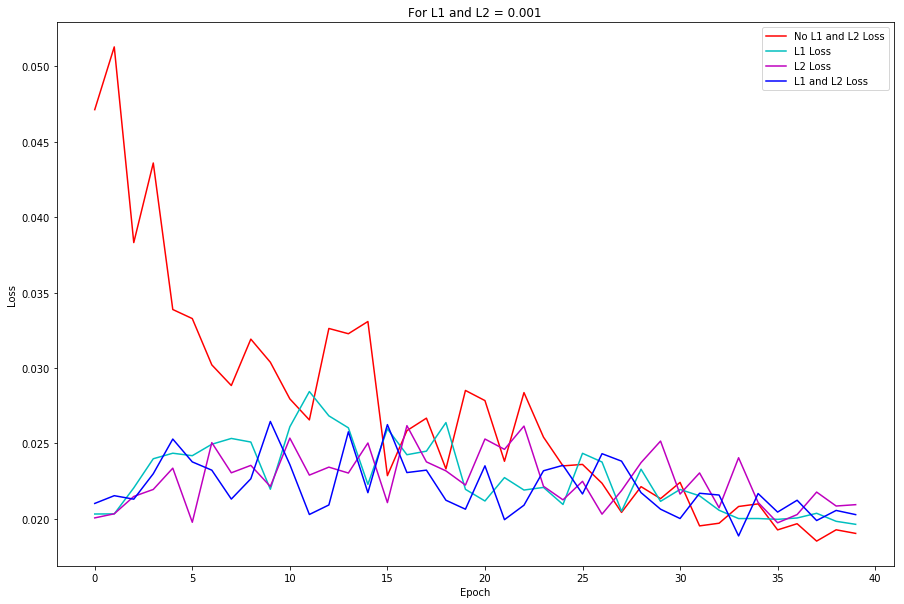

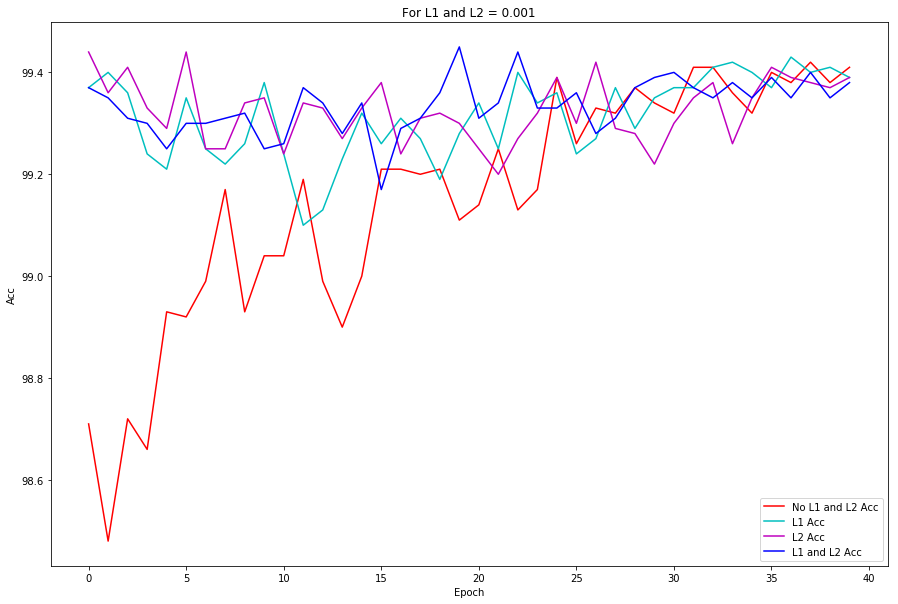

0.11884287219047546


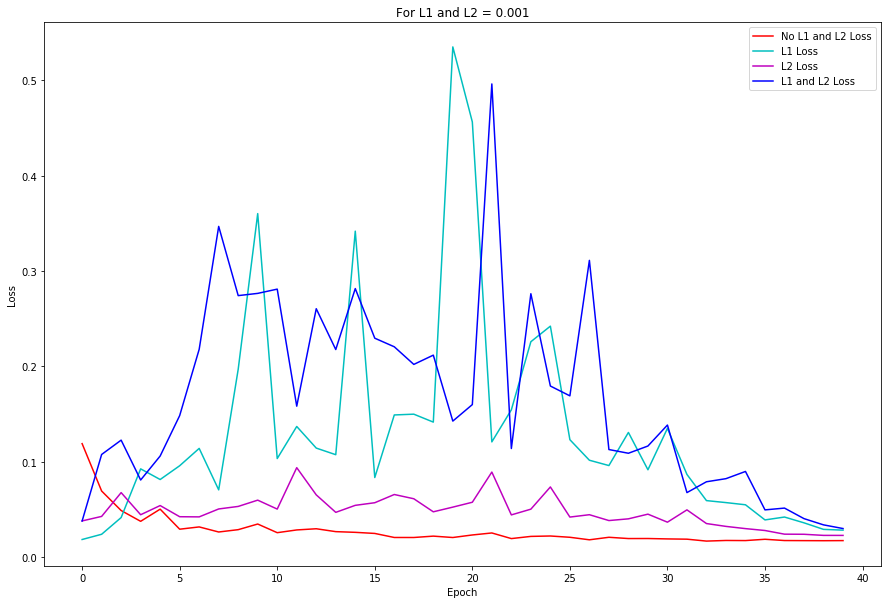

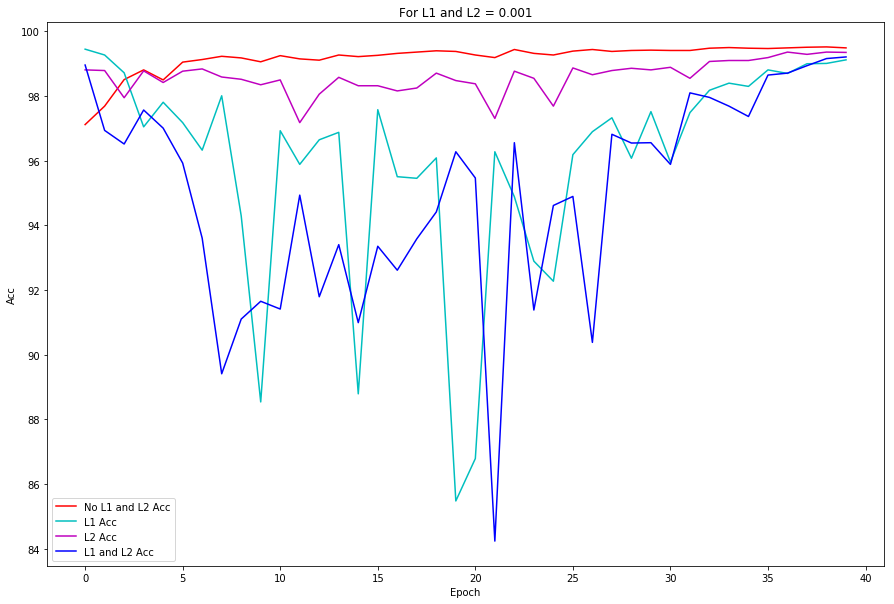

In [43]:
no_reg_loss = no_reg_acc = []
l1_loss = l1_acc = []
l2_loss = l2_acc = []
l1_l2_loss = l1_l2_acc = []
lam_dict = {}
for grp in grps:
    
    no_reg_loss = ast.literal_eval(list(df_grp.get_group(grp)['test_losses'])[0])
    no_reg_acc = ast.literal_eval(list(df_grp.get_group(grp)['test_acc'])[0])
    
    l1_loss = ast.literal_eval(list(df_grp.get_group(grp)['test_losses'])[1])
    l1_acc = ast.literal_eval(list(df_grp.get_group(grp)['test_acc'])[1])
    
    l2_loss = ast.literal_eval(list(df_grp.get_group(grp)['test_losses'])[2])
    l2_acc = ast.literal_eval(list(df_grp.get_group(grp)['test_acc'])[2])
    
    l1_l2_loss = ast.literal_eval(list(df_grp.get_group(grp)['test_losses'])[3])
    l1_l2_acc = ast.literal_eval(list(df_grp.get_group(grp)['test_acc'])[3])
    
#     epoch_count = list(list(df_grp.get_group(grp)['epoch_count'])[0])
    epoch_count = range(0, 40)
    print(no_reg_loss[0])
    plt.figure(1, figsize=[15,10])
    plt.plot(epoch_count, no_reg_loss, color='r')
    plt.plot(epoch_count, l1_loss, color='c')
    plt.plot(epoch_count, l2_loss, color='m')
    plt.plot(epoch_count, l1_l2_loss, color='b')
    plt.legend(['No L1 and L2 Loss', 'L1 Loss', 'L2 Loss', 'L1 and L2 Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("For L1 and L2 = 0.001")
    plt.show()
    
    plt.figure(1, figsize=[15,10])
    plt.plot(epoch_count, no_reg_acc, color='r')
    plt.plot(epoch_count, l1_acc, color='c')
    plt.plot(epoch_count, l2_acc, color='m')
    plt.plot(epoch_count, l1_l2_acc, color='b')
    plt.legend(['No L1 and L2 Acc', 'L1 Acc', 'L2 Acc', 'L1 and L2 Acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title("For L1 and L2 = 0.001")
    plt.show()
    